# Machine Learning I - Practical III

Name: Artemii Shlychkov

Course: Computational Neuroscience

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. For each of these cells, the expression of several thousand genes was measured. In the original study, the authors were interested in clustering the cells into types. 

A selection of 5000 cells and the 1000 most informative genes was made for run time reasons. Original cell type labels determined by the authors are provided for comparison.


In [1]:
# Prepare
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from scipy.stats import multivariate_normal
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.mixture
import sklearn
from scipy import sparse
import matplotlib
import scipy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='white', palette='colorblind')

## Step 0: Loading and normalizing count data

In [2]:
def lognormalize_counts(tasic_dict):
    
    counts = tasic_dict['counts']
    
    # trying to catch all formats in which the counts might be loaded
    if scipy.sparse.issparse(counts):
        counts = counts.toarray()
    elif isinstance(CPM, np.matrix):
        counts = np.squeeze(np.asarray(counts))
    else:
        raise TypeError(f"Data format is {type(counts)} but should be np.martix or a sparse matrix.")
    
    #normalize and logtransform counts
    libsizes = counts.sum(axis=1)
    CPM = counts / libsizes[:, None] * 1e+6
        
    logCPM = np.log2(CPM + 1) 
    tasic_dict['logCPM'] = logCPM  
    
    return tasic_dict

In [3]:
tasic_1k = lognormalize_counts(pickle.load(open('tasic_subset_1kselected.pickle', 'rb'))) 

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_15659/3293639000.py:1: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  tasic_1k = lognormalize_counts(pickle.load(open('tasic_subset_1kselected.pickle', 'rb')))


## Step 1: Linear dimensionality reduction with PCA 

Here I use principle component analysis (PCA) to reduce the dimensionality of the dataset.

First, I implement PCA "by hand". Below is a function that computes all possible principle components, and returns them along with the fraction of variance they explain.

In [7]:
def PCA_manual(data):
    '''
    Function that performs PCA on the input data

    Args: (cells,genes): shaped array of log transformed cell counts
    Returns:
        fraction_variance_explained: (genes,): shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes): shaped array containing the principal components as columns
    '''

    # load data
    data = tasic_1k['logCPM']

    # Center the data
    data_centered = data - np.mean(data, axis=0)

    # Calculate covariance matrix
    cov_matrix = np.cov(data_centered.T)

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Calculate fraction of variance explained
    fraction_variance_explained = sorted_eigenvalues / \
        np.sum(sorted_eigenvalues)

    # Principal components are basically the eigenvectors
    principal_components = sorted_eigenvectors

    # return fraction of variance explained and principal components

    return fraction_variance_explained, principal_components

In [8]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])

It can be now shown how much variance the first PCs explain as follows:

- Plot the variance explained of the `n`-th PC vs. `n`

- Plot the cumulative variance explained for the `n` PCs with highest variance explained vs. `n`

From the latter plot one should be able to see how much PCs is needed to keep to explain at least `x`% of the variance.

Fo example, we can indicate how many components are needed to keep to explain 50%, 75%, 90% and 99%, respectively.

Number of PCs explaining 50.0% of variance: 4
Number of PCs explaining 75.0% of variance: 42
Number of PCs explaining 90.0% of variance: 192
Number of PCs explaining 99.0% of variance: 589


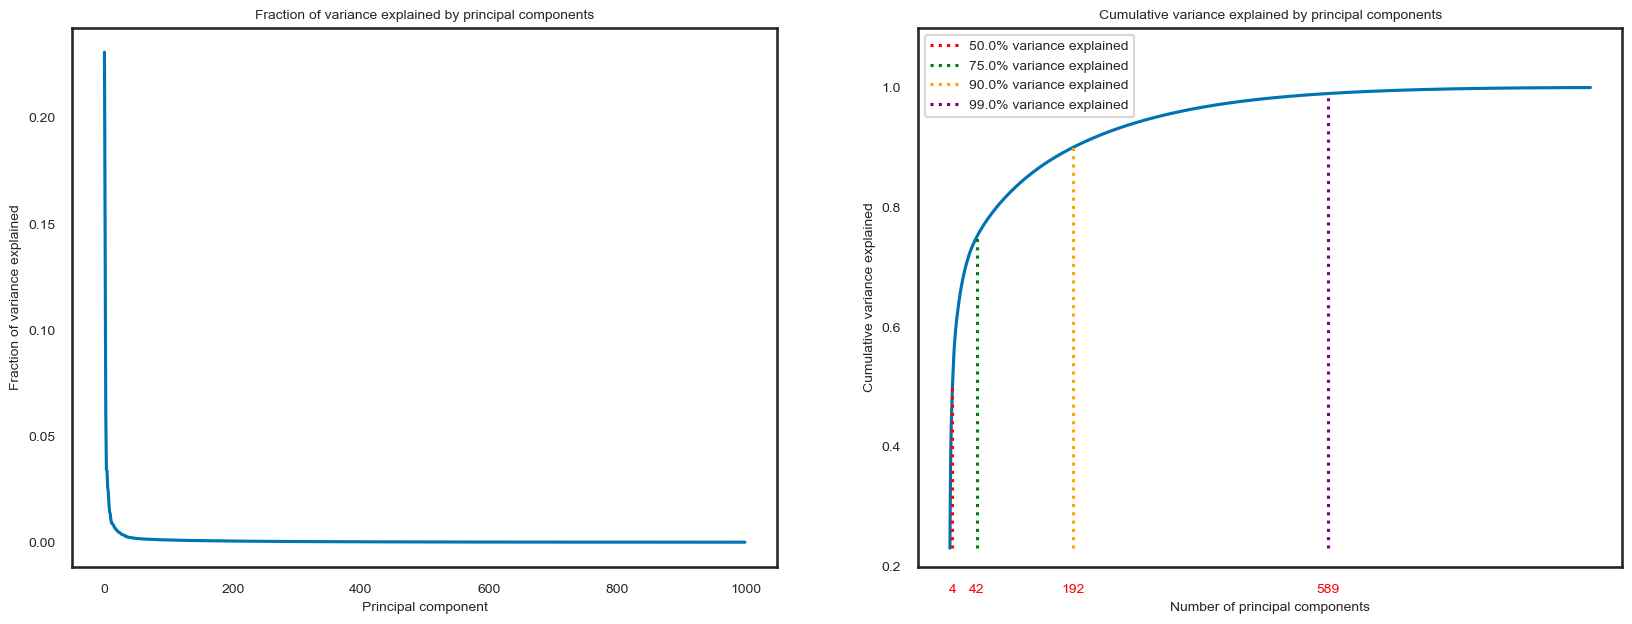

In [9]:
plt.figure(figsize=(20, 7))

plt.subplot(121)
plt.plot(var_expl)
plt.xlabel('Principal component', fontsize=10)
plt.ylabel('Fraction of variance explained', fontsize=10)
plt.title('Fraction of variance explained by principal components', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(122)

# plt.plot(np.cumsum(var_expl))
thresholds = [0.5, 0.75, 0.9, 0.99]
components = [np.where(np.cumsum(var_expl) > threshold)[0][0]
              for threshold in thresholds]
COLORS = ['red', 'green', 'orange', 'purple']

plt.subplot(122)
plt.plot(np.cumsum(var_expl))

upper_limit = 1.1
lower_limit = 0.2

for i, component in enumerate(components):
    # Calculate the proportion of the threshold value relative to the plot's y-axis range
    y_value_at_component = np.cumsum(var_expl)[component]
    ymax_proportion = (y_value_at_component-lower_limit) / \
        (upper_limit - lower_limit)
    ymin_proportion = (np.cumsum(var_expl).min() -
                       lower_limit) / (upper_limit - lower_limit)

    plt.axvline(component, color=COLORS[i], linestyle=':', label=f'{
                thresholds[i]*100}% variance explained', ymax=ymax_proportion, ymin=ymin_proportion)
    print(f"Number of PCs explaining {
          thresholds[i]*100}% of variance: {components[i]}")


plt.xticks(components, fontsize=10, color='red')
plt.yticks(fontsize=10)
plt.ylim(lower_limit, upper_limit)

plt.xlabel('Number of principal components', fontsize=10)
plt.ylabel('Cumulative variance explained', fontsize=10)
plt.title('Cumulative variance explained by principal components', fontsize=10)
plt.legend(fontsize=10)



Number of PCs explaining 50.0% of variance: 4

Number of PCs explaining 75.0% of variance: 42

Number of PCs explaining 90.0% of variance: 192

Number of PCs explaining 99.0% of variance: 589

Below is a function to select the `n` PCs needed to explain at least `x`% of the variance.

In [10]:
def select_PCs(variance_explained, principal_components, percent_variance=None):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    Args: 
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    Returns:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)

    '''

    # INSERT YOUR CODE HERE
    # number of PCs where the cumulative variance exceeds the threshold
    n = np.where(np.cumsum(var_expl) > percent_variance)[0][0]
    # slecting variance for the first n PCs
    variance_explained_kept = variance_explained[:n]
    # selecting the first n PCs
    principal_components_kept = principal_components[:, :n]

    return variance_explained_kept, principal_components_kept

Now I select the PC's explaining 75% of variance

In [11]:
_,PCs75 = select_PCs(var_expl,PCs,percent_variance=0.75) # select PCs explaining 75% of variance
print(f"Number of PCs explaining 75% of variance: {PCs75.shape[1]}")

Number of PCs explaining 75% of variance: 42


To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [12]:
def compute_PCA_scores(data, principal_components):
    '''Function that returns the PC scores for each data point
    Args: 
        data: (cells,genes)-shaped array of log transformed cell counts
        principal_components: contains the principal components as columns
    Returns:
        pc_scores: (cells,n_PCs_kept)-shaped array of PC scores

    '''

    data = data - np.mean(data, axis=0)  # center the data

    # project the data onto the principal components to get the PC scores (aka the new coordinates in the PC space)
    pc_scores = data @ principal_components

    return pc_scores

In [13]:
# compute PC scores for the 75% variance explained PCs
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'], PCs75)

Finally, visualize the top 5 PCs as a pairwise scatterplot. Use a 5x2 subplot grid of scatter plots, and use one subplot for each pair of components.

Also, use the colors provided in `data['clusterColors']` and the cluster information in `data['clusters']` to color each data point according to its original cluster identity. The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-postive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

In [12]:
def plot_PCs(data_transformed, color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
    Args:
        data_transformed: (cells,n_PCs_kept)-shaped array of PC scores
        color_per_datapoint: (cells,)-shaped array of color strings, one color for each cell
    '''
    fig, ax = plt.subplots(5, 2, figsize=(10, 15), tight_layout=True)

    subplot_count = 0
    for i in range(0, 5):
        for j in range(i + 1, 5):
            x = subplot_count // 2
            y = subplot_count % 2

            ax[x, y].scatter(np.asarray(data_transformed[:, j]), np.asarray(
                data_transformed[:, i]), c=color_per_datapoint, s=0.7)
            ax[x, y].set_xlabel(f"PC {j + 1}")
            ax[x, y].set_ylabel(f"PC {i + 1}")

            subplot_count += 1

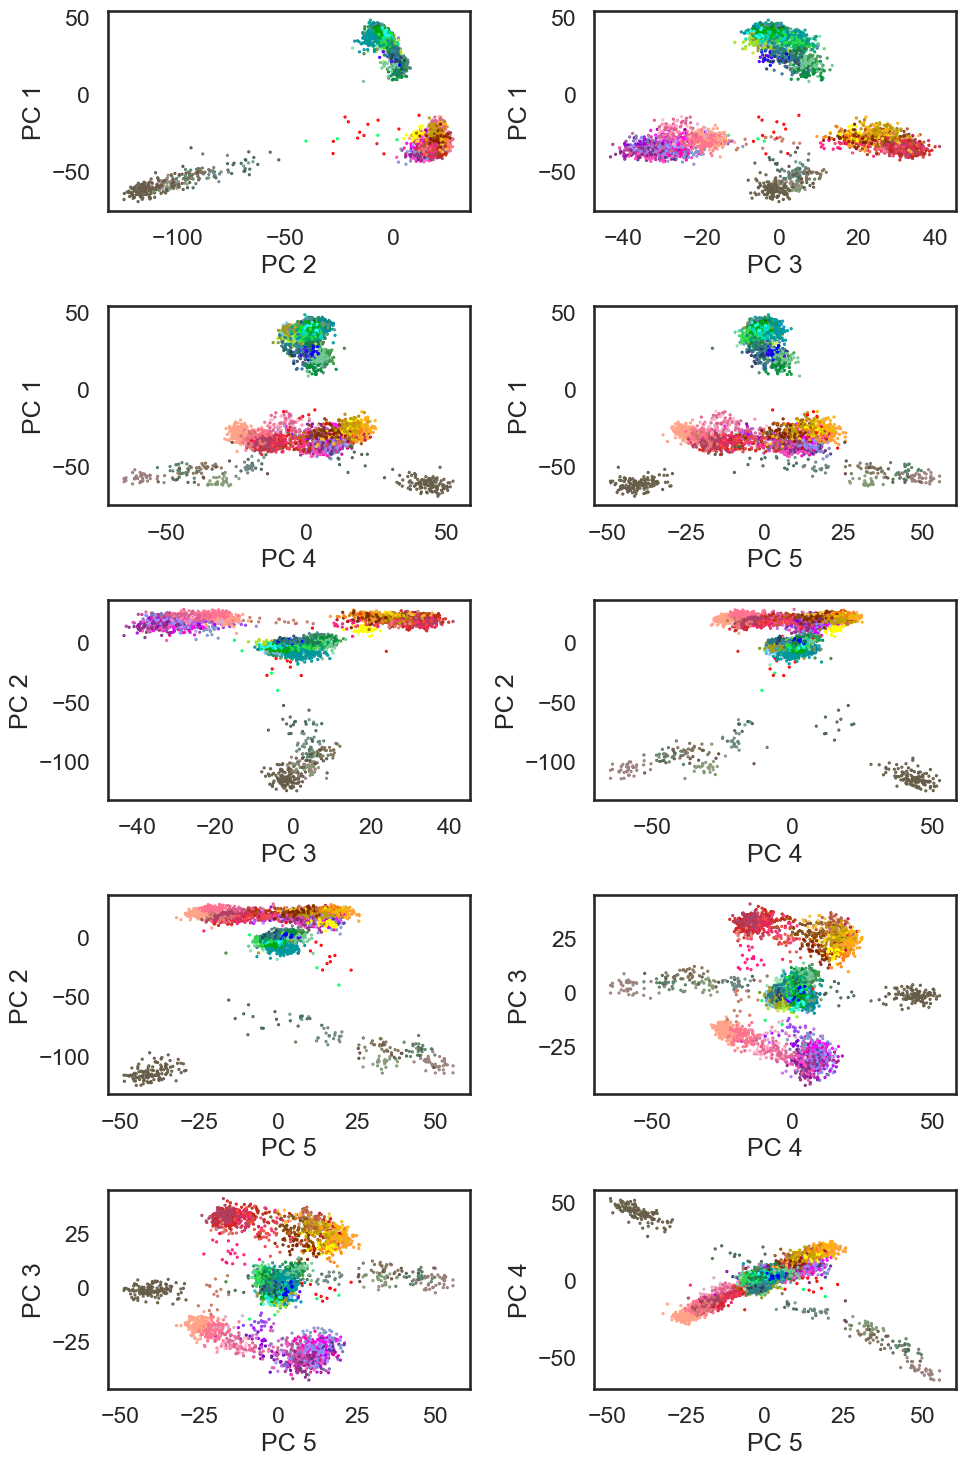

In [13]:
# Visualize the PCs
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'],color_per_datapoint)

First of all, we can observe, that non-neuron cells (dark colours) are well isolated in separate clusters within all PC subspaces, which is a good sign. In fact PC1 and PC2 do the best in terms of distinguishing non neuronal cells from neurons. Although different types of non-neuronal cells can be further discriminated in other PC subspaces, namely, PC4 vs PC5. Correspondigly, PC4-PC5 subspace is the worst in terms of isloating different neuron types. 

We can also observe that in the first subplot with the first two most significant PC's, 3 distict clusters are present: one for excitatory neurons, one for non-neuronal cells and the last one for the rest of the neurons.  In fact excitatory cells form distinct clusters within almost all PC subspaces. In PC1-PC2 subspace, pinkish dots (VIP-poitive neurons) are further dissected from the orange and red group (somatostatin and parvalbumin positive) 


## Step 2: Comparison with PCA implemented by sklearn

Here I use the sklearn implementation of PCA. 

`svd_solver='full'` is used for fully reproducible results.

In [14]:
def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn

    Args: 
        (cells,genes)-shaped array of log transformed cell counts
    Returns:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''

    # load data
    pca = PCA()
    pca.fit(data)  # fit the PCA model to the data
    # get the fraction of variance explained by each PC
    fraction_variance_explained = pca.explained_variance_ratio_
    principal_components = pca.components_  # get the principal components

    return fraction_variance_explained, principal_components.T

In [15]:
#do sklearn-PCA on selected genes
var_expl_sklearn,PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
#select components as before
_,PCs_sklearn75 = select_PCs(var_expl_sklearn,PCs_sklearn,0.75)
#get PC scores
PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'],PCs_sklearn75)

To see if the manual PCA yielded the same PC weights as the sklearn PCA, one can just take the two matrices of principle components and plot their entries against each other. (Note: This assumes they are sorted by variance explained)

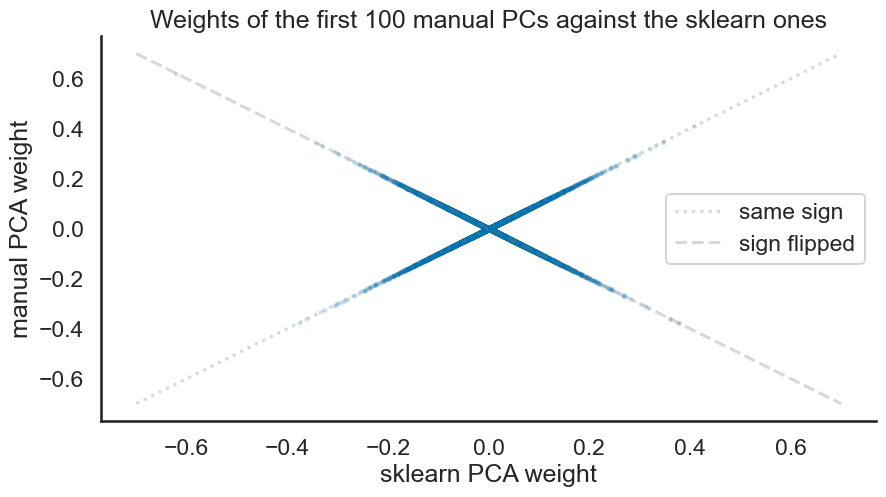

In [16]:
n_evs_to_compare=100
    
plt.figure(figsize=(10,5))
plt.scatter(PCs_sklearn[:,:n_evs_to_compare].flatten(),PCs[:,:n_evs_to_compare].flatten(),s=5,alpha=0.1)
plt.plot([-.7,.7],[-.7,.7],':',c='tab:gray',label='same sign',alpha=0.3)
plt.plot([-.7,.7],[.7,-.7],'--',c='tab:gray',label='sign flipped',alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

In [17]:
# check out some sample PCs 
for pc_id in [73, 74, 85, 86, 88]:
    print('PC #%u\n' % (pc_id),'sklearn:',PCs_sklearn[:5,pc_id])
    print(' manual: ',PCs[:5,pc_id],'\n')

PC #73
 sklearn: [-0.00034608  0.00562153 -0.00114842 -0.00634457 -0.03554372]
 manual:  [ 0.00034608 -0.00562153  0.00114842  0.00634457  0.03554372] 

PC #74
 sklearn: [-0.00804321 -0.00048314  0.0057423  -0.0025718  -0.0014449 ]
 manual:  [ 0.00804321  0.00048314 -0.0057423   0.0025718   0.0014449 ] 

PC #85
 sklearn: [-0.00392872  0.00994615  0.00860339  0.00106828 -0.04378149]
 manual:  [-0.00392872  0.00994615  0.00860339  0.00106828 -0.04378149] 

PC #86
 sklearn: [ 0.0050671   0.0111035  -0.00183549 -0.00219335 -0.04003994]
 manual:  [-0.0050671  -0.0111035   0.00183549  0.00219335  0.04003994] 

PC #88
 sklearn: [ 0.00103559 -0.00670992 -0.00236122 -0.0083578   0.07419216]
 manual:  [ 0.00103559 -0.00670992 -0.00236122 -0.0083578   0.07419216] 



It can be noted that the absolute values of the manually obtained PC's allign perfectly with the scikit ones, however half the signs of the PC vector entries are opposite, which is due to the fact that varience in x direction is the same as varience in -x direction. This sign difference doesn't affect the overall interpretation of the principal components, as it only reflects the direction of the eigenvector and the magnitude (absolute value) of the PC vectors remains the same.

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Step 3: Nonlinear dimensionality reduction with t-SNE

Here I use the nonlinear dimensionality reduction technique tSNE and look at visualizations of the data set. First, I run the default t-SNE and store the result in a variable to keep, as it will be used for plotting further on. I plot the result of default t-SNE with the original cluster colors. For this and the following, I use the PCs explaining 75% of the variance as provided in ```tasic_1k['PCA_75']```.


In [18]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.

    Args:
        tsne_results: (n,2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''

    # make sure we can do both single and multiple plots and are flexible regarding input
    if type(tsne_results) == list:
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters) == list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters]*num_plots

    if len(labels) == 1:
        labels = labels*num_plots

    # ensure a long enough color list even if we plot more than
    n_clusters = len(np.unique(clusters))
    # the original number of clusters
    n_colors = len(tasic_1k['clusterColors'])
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate(
            (tasic_1k['clusterColors'], tasic_1k['clusterColors'][:n_extra_colors]))
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(1, num_plots, figsize=(10, num_plots*10))
    if num_plots == 1:
        if not np.all(tasic_1k['clusters'] == clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:, 0], tsne_results[0]
                   [:, 1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters'] == clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:, 0], tsne_results[i]
                          [:, 1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()

In [19]:
original_clusters = tasic_1k['clusters']

tsne = TSNE()
tsne_results = tsne.fit_transform(np.asarray(tasic_1k["PCA_75"]))

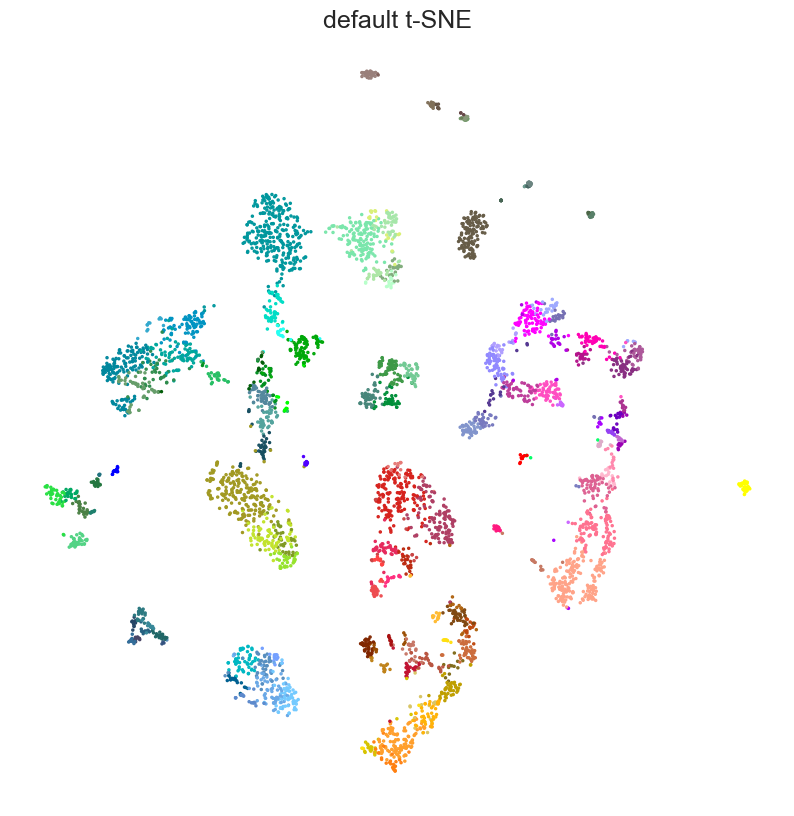

In [20]:
plot_tsne(tsne_results, original_clusters, labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades off local and global structure. Its default value is 30. Below I run the tSNE with some perplexity values, and plot the results next to each other. Below is a slightly modified function that plots all t-SNE plots side by side for easier comparison.

In [21]:
def plot_combined_tsne(tsne_results_list, cluster_lists, labels, tasic_1k, size):
    '''Plot combined tSNE results in a single figure with multiple subplots.

    Args:
        tsne_results_list: List of (n,2)-shaped arrays containing tSNE-transformed data.
        cluster_lists: List of (n,)-shaped arrays containing cluster labels.
        labels: List of titles for the subplots.
        tasic_1k: Dictionary containing 'clusterColors' and possibly 'clusters' for original coloring.
    '''

    num_plots = len(tsne_results_list)

    # Adjust size as needed
    fig, axs = plt.subplots(1, num_plots, figsize=size)

    for i, (tsne_results, clusters) in enumerate(zip(tsne_results_list, cluster_lists)):
        # Determine the unique clusters and appropriate colors
        n_clusters = len(np.unique(clusters))
        n_colors = len(tasic_1k['clusterColors'])

        if n_clusters > n_colors:
            n_extra_colors = n_clusters - n_colors
            colors = np.concatenate(
                (tasic_1k['clusterColors'], tasic_1k['clusterColors'][:n_extra_colors]))
        else:
            colors = tasic_1k['clusterColors']

        # Check if permutation is needed
        if not np.all(tasic_1k.get('clusters', []) == clusters):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors

        # Plotting
        axs[i].scatter(tsne_results[:, 0], tsne_results[:, 1],
                       s=1, color=[current_colors[j] for j in clusters])
        axs[i].set_title(labels[i])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_axis_off()

    plt.tight_layout()
    plt.show()

In [22]:
# Try different perplexities
tsne_perplexity = []
tsne_perplexity.append(tsne_results)
tsne_perplexity.append(TSNE(perplexity=5).fit_transform(np.asarray(tasic_1k["PCA_75"])))
tsne_perplexity.append(TSNE(perplexity=100).fit_transform(np.asarray(tasic_1k["PCA_75"])))



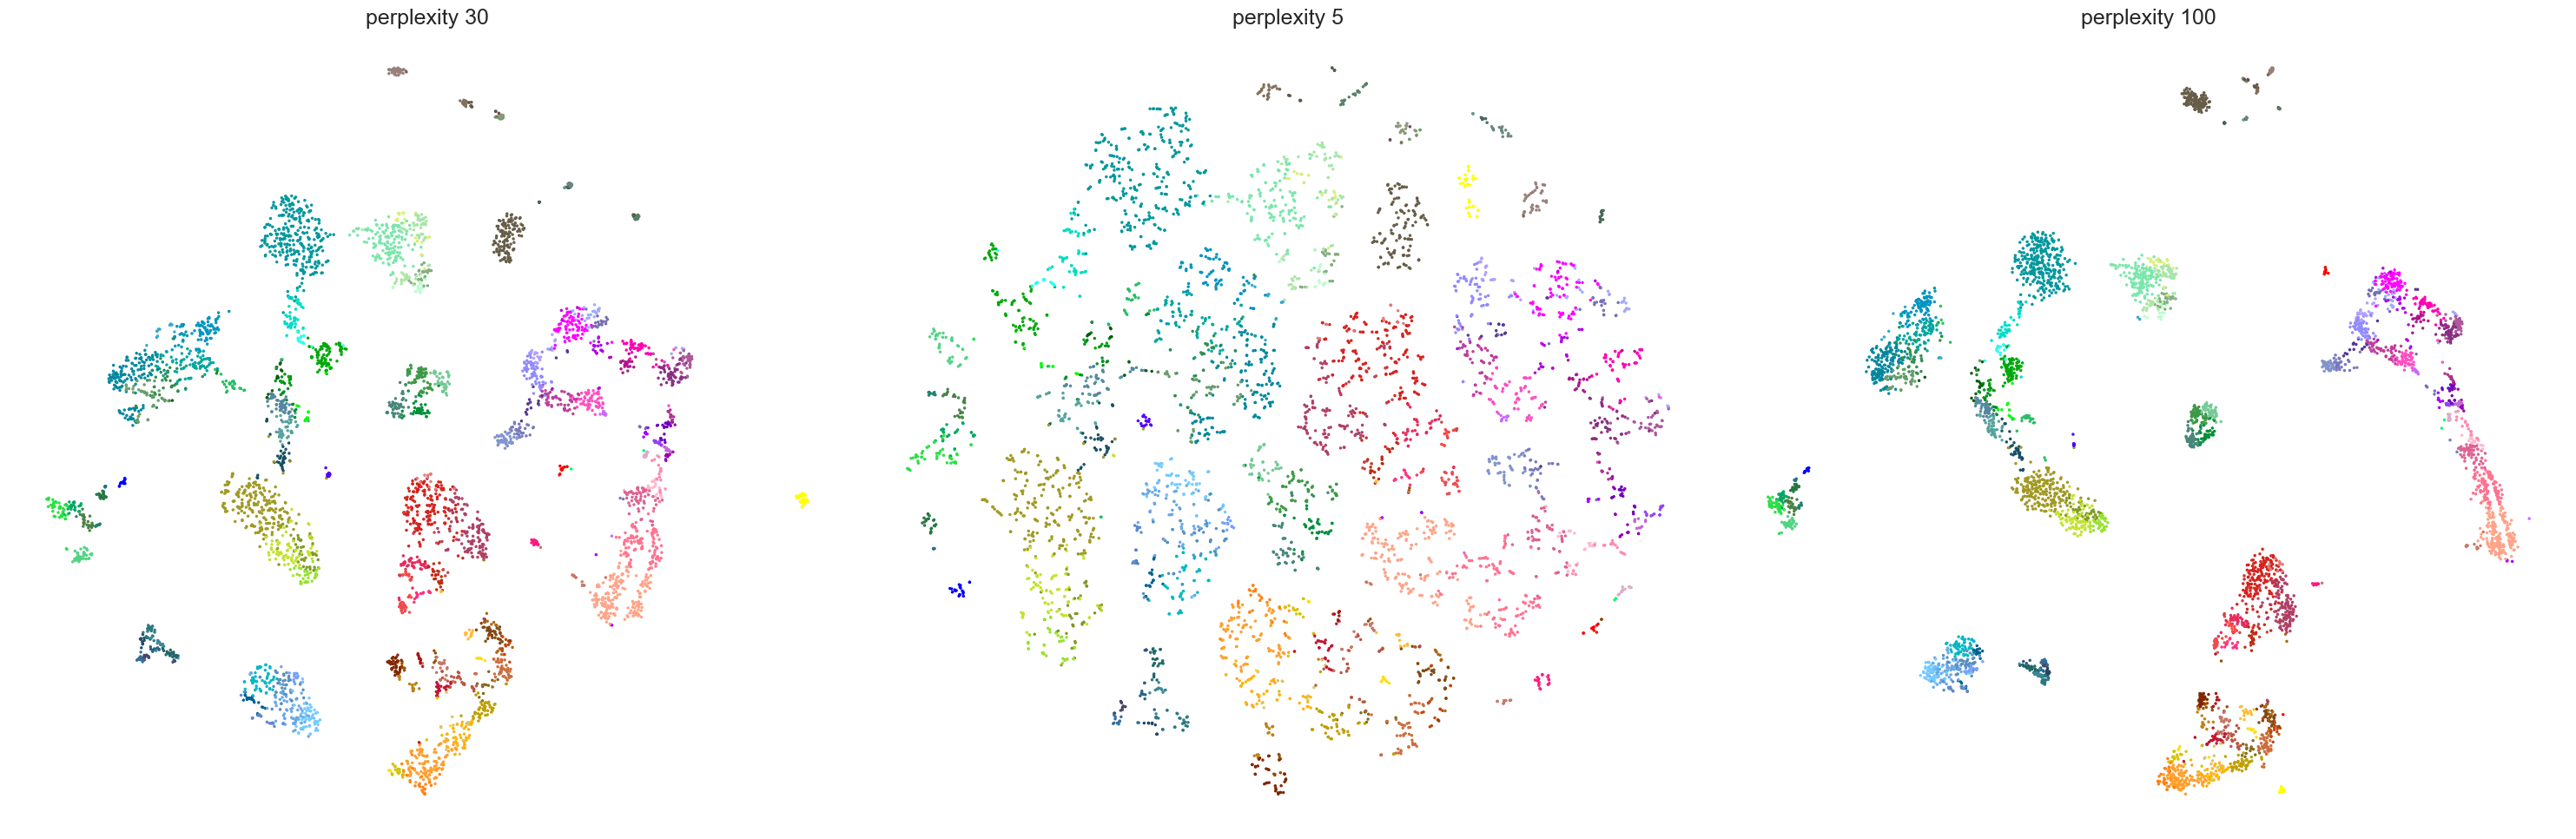

In [23]:
# Plot results
cluster_list = [original_clusters]*3
plot_combined_tsne(tsne_perplexity,cluster_list,labels=['perplexity 30', 'perplexity 5', 'perplexity 100'], tasic_1k=tasic_1k, size=(30, 10))

Perplexity parameter defines the width of the kernel used in calculating high dimensional similarities (i.e. kernel width is adaptively chosen to achive the desired perplexity). The more the perplexity - the more the attractive forces between the similar particles, which results in tighter layout of the clusters and also worse discrimination between some adjusent clusters. Too low perplexity swings the balance in favour of repellant forces, as a result the particals are distributed too losely and it is harder to infer the clusters. The default perplexity value (30) yields the best clusterisation, as it reflects the best balance between the repellant and attractive forces.  

## Step 4: Cluster the data using k-Means

So far, I only visualized the data and plotted it with the original cluster labels. As a next step, I implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. I use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters. Results are plotted as t-SNE plot colored by clusters.

In [24]:
def run_KMeans(n_clusters):
    '''Function that performs K-means clustering for a given number of clusters
        Args:
            number of clusters
        Returns: 
            Cluster labels (K-means prediction)
    '''

    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    kmeans_result = kmeans.fit(np.asarray(tasic_1k["PCA_75"])).labels_

    return kmeans_result

In [25]:
# Run kmeans with different numbers of clusters (5, 10, 20, 50)
kmeans_results = []
for num_c in [5, 10, 20, 50]:
    kmeans_results.append(run_KMeans(num_c))

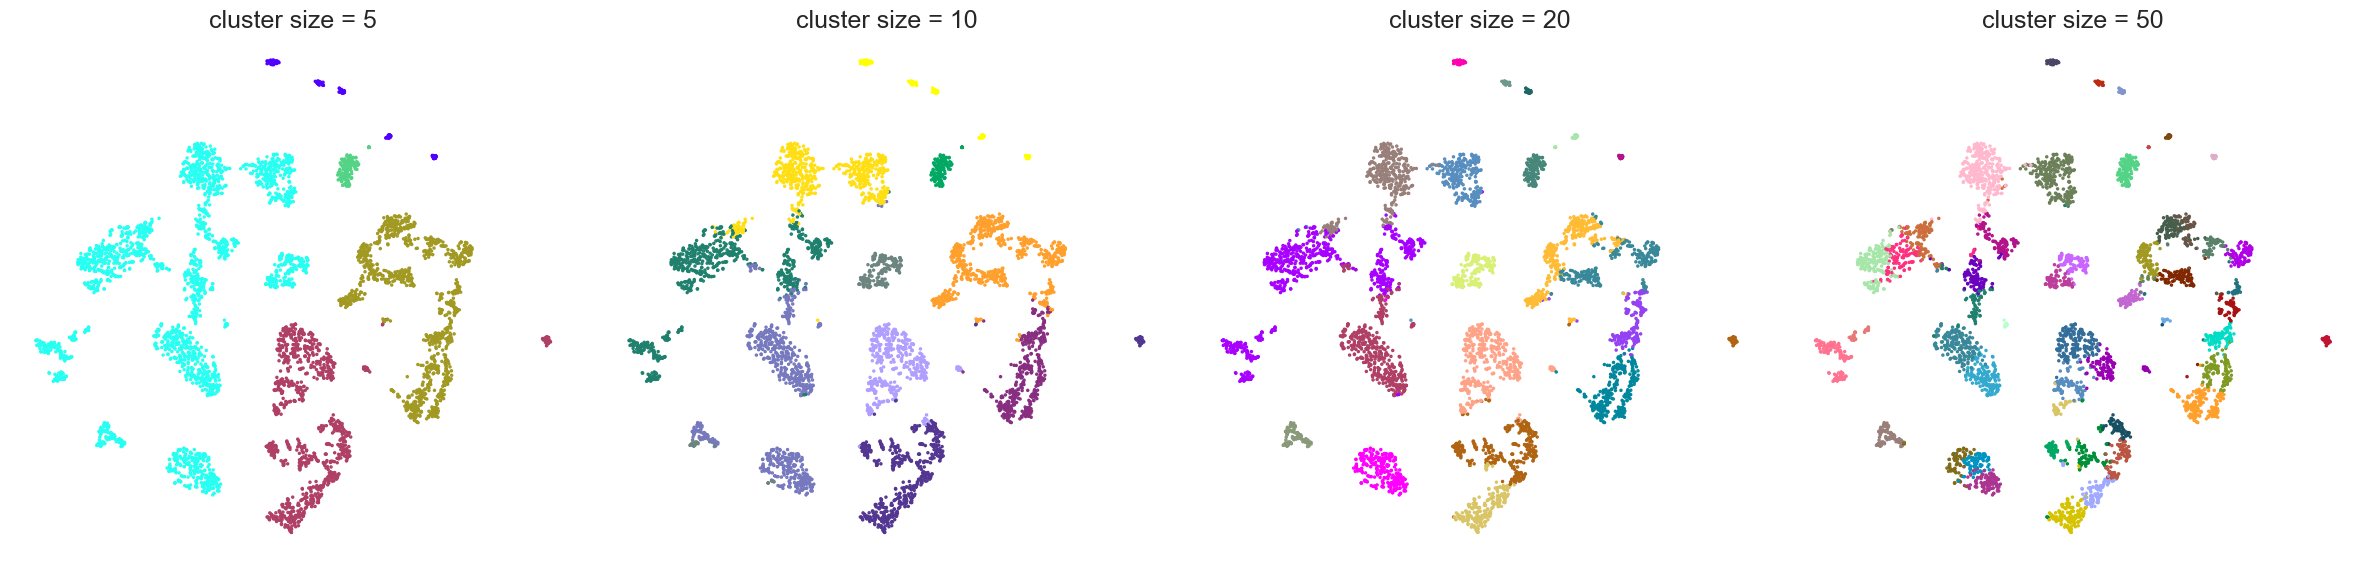

In [26]:
tsne_results_list = [tsne_results, tsne_results, tsne_results, tsne_results]
plot_combined_tsne(tsne_results_list, kmeans_results, ["cluster size = 5", "cluster size = 10", "cluster size = 20", "cluster size = 50"], tasic_1k = tasic_1k, size=(24, 6))

As expected, with the smaller number of imposed clusters, more data points are assigned to these clusters via color labeling, although the overal structure yielded by t-SNE is preserved 

##  Step 5: Clustering using Gaussian Mixture Models 

Finally, I implement clustering with Gaussian Mixture models. Firstly, I generate some toy data to later verify the correct implementation of the algorithm and then implement the algorithm using EM and run it on the transcriptomics data set. 

1000 data points are sampled from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

The sampled data points are plotted and color indicates the cluster each point came from. Plot the cluster means as well.

In [41]:
def sampleData(N, means, covariances, priors):
    '''Generate N samples from a Mixture of Gaussian distribution.
    
    Args:
        N: number of samples
        means: (n_cluster,n_dimensions)-shaped array of mean vectors
        covariances: (n_dimensions,n_dimensions,n_cluster)-shaped array of covariance matrices
        prioirs: (n_cluster)-shaped arrays of priors / mixing coefficients
    Returns:
        data: (N,n_dimensions)-shaped array of simulated data
        cluster_ids: (N,)-shaped array of integers that hold the cluster assignment for each data point

    '''
    
       
    np.random.seed(1)
    cluster_ids = np.random.choice([0, 1, 2], N, p = priors) # return a vector of N cluster ids sampled from the given priors
    data = np.array([np.random.multivariate_normal(mean=means[id], cov=covariances[id]) for id in cluster_ids]) # create a data point for each entry of the cluster_ids vector by sampling from the multivariate normal distribution with the means and covariances correcponding to the cluster_ids
    
     
    return data,cluster_ids 

In [42]:
# Set up sampling

N = 1000
toy_means = np.array([[0, 0], [5, 1], [0, 2]]) # initialize means for the 3 clusters
toy_covs = np.array([                          # initialize covariance matrices for the 3 clusters
    [[1, 0], [0, 1]],
    [[2, 1], [1, 2]],
    [[1, -0.5], [-0.5, 1]]
    ]) 
toy_priors = np.array([0.3, 0.5, 0.2])       # initialize priors for the 3 clusters

toy_data, toy_cluster_ids_true = sampleData(N, toy_means, toy_covs, toy_priors)

In [43]:
def plot_clustering(data,cluster_ids,means,title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    Args:
        data: (N,n_dimensions)-shaped array of data
        cluster_ids: (N,)-shaped array of integers that hold the cluster assignment for each data point
        means : (n_cluster,n_dimensions)-shaped array of mean vectors
        title: string that is added as title

    '''
    cmap = matplotlib.colormaps["tab10"]
    colors = cmap(np.linspace(0, 1, len(means)))
    
    
    # INSERT YOUR CODE HERE
    
    plt.figure(figsize=(6, 6))
    plt.scatter(x=data[:, 0], y=data[:, 1], c=colors[cluster_ids], s=0.7)
    for i, mean in enumerate(means):
        if i == 0:
            plt.scatter(mean[0], mean[1], s=80, c="yellow", marker='*', edgecolor="black", linewidth=1, label="means")
        else:
            plt.scatter(mean[0], mean[1], s=80, c="yellow", marker='*', edgecolor="black", linewidth=1)
    plt.title(title)
    plt.legend()


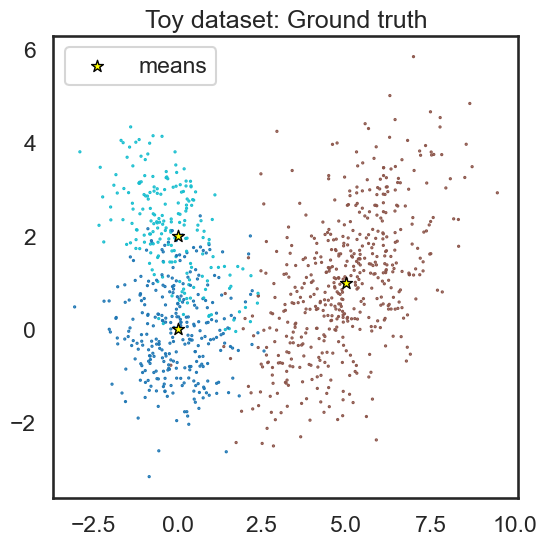

In [44]:
plot_clustering(toy_data,toy_cluster_ids_true,toy_means,'Toy dataset: Ground truth')

Now I can implement the EM algorithm to fit a Gaussian mixture model on the PCA-transformed data. The data points are clustered by inferring their cluster labels from your mixture model (by using maximum a-posteriori classification). 

It is important to initialize the means, covariances and mixing coefficients appropriately. Also, during optimization, covariance matrices can become singular. To prevent this, one can add a small constant (like $10^{-6}$) to the diagonal.

In [45]:
def initialize_clusters(data, n_clusters):
    '''Function that initializes the means and covariances for the EM algorithm
    Args:
        data: (N,n_dimensions)-shaped array of data
        n_clusters: number of clusters
    Returns:
        means: (n_cluster,n_dimensions)-shaped array of mean vectors
        covariances: (n_dimensions,n_dimensions,n_cluster)-shaped array of covariance matrices
        priors: (n_cluster)-shaped arrays of priors / mixing coefficients
    '''
    clusters = []
    k_means = KMeans(n_clusters).fit(data)
    mu_k = k_means.cluster_centers_

    # initialize a dictionary containing means, covariances and probabilities for each cluster
    for i in range(n_clusters):
        clusters.append({
            # the initial weight (or probability) of each cluster.
            'pi_k': 1.0 / n_clusters,
            # corresponding mean from the mu_k array obtained from KMeans
            'mu_k': mu_k[i],
            # the initial covariance matrix of each cluster.
            'cov_k': np.cov(data, rowvar=False)
        })

    return clusters

In [46]:
def expectation_step(data, clusters):
    '''Function that performs the E-step of the EM algorithm
    Args:
        data: (N,n_dimensions)-shaped array of data
        clusters: list of dictionaries, each containing the parameters for a cluster
    Returns:
        expectation: N,n_clusters)-shaped array of expected cluster assignments
        totals: (N,1)-shaped array of total probabilities
    '''
    global expectation, totals
    N = data.shape[0]  # number of data points
    K = len(clusters)  # number of clusters
    totals = np.zeros((N, 1), dtype=np.float64)  # initialize totals array
    # initialize expectation array
    expectation = np.zeros((N, K), dtype=np.float64)

    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']

        # add a small value to the diagonal of the covariance matrix to avoid singular matrices
        cov_k += 1e-6 * np.identity(data.shape[1], dtype=np.float64)

        expectation[:, k] = (
            pi_k * (stats.multivariate_normal(mean=mu_k, cov=cov_k).pdf(data)))

    totals = np.sum(expectation, 1)
    expectation /= np.expand_dims(totals, 1)

In [47]:
def maximization_step(data, clusters):
    '''Function that performs the M-step of the EM algorithm
    Args:
        data: (N,n_dimensions)-shaped array of data
        clusters: list of dictionaries, each containing the parameters for a cluster
    Returns:
        updated cluster parameters
    '''
    global expectation

    N = float(data.shape[0])  # number of data points

    for k, cluster in enumerate(clusters):

        # Extract the expectation values for cluster k
        expectation_k = expectation[:, k]

        # Calculate N_k (total responsibility for cluster k)
        N_k = np.sum(expectation_k)

        # Update cluster parameters
        pi_k = N_k / N
        mu_k = np.sum(expectation_k.reshape(-1, 1) * data, axis=0) / N_k
        cov_k = (expectation_k.reshape(-1, 1) *
                 (data - mu_k)).T @ (data - mu_k) / N_k

        # Update cluster parameters in the cluster dictionary
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [48]:
def gmm(data, n_clusters, verbose=True, max_iter=1000):
    '''Function that fits a mixture of gaussians to data.

        Args:
            data: (n_samples,n_features)-shaped array of data points
            n_components: int, number of clusters / mixture components
            verbose: bool, if True, print current likelihood after each EM iteration
            max_iter: maximum number of EM iterations

        Returns:
            cluster_ids: (N,)-shaped array of integers that hold the cluster assignment for each data point
            means: (n_cluster,n_dimensions)-shaped array of fit mean vectors
            covs: (n_dimensions,n_dimensions,n_cluster)-shaped array of fit covariance matrices
            priors: (n_cluster)-shaped arrays of fit priors / mixing coefficients

        '''

    clusters = initialize_clusters(data, n_clusters)  # initialize clusters

    scores = np.zeros((data.shape[0], n_clusters))  # initialize scores array
    history = []  # initialize history list

    for i in range(max_iter):

        expectation_step(data, clusters)  # E-step
        maximization_step(data, clusters)  # M-step

    # calculate the log likelihood of the data given the model
    scores = np.log(expectation)

    # extract the means from the cluster dictionary
    cluster_means = np.array([cluster['mu_k'] for cluster in clusters])
    # assign each data point to the cluster with the highest score
    cluster_ids = np.argmax(scores, axis=1)
    return cluster_ids, cluster_means

Now the implementation can be tested on the toy dataset specifying the correct number of clusters and making sure the code works correctly. 

In [49]:
toy_cluster_ids_fit, toy_means_fit = gmm(toy_data,3)

/Users/a1/miniconda3/envs/fuck2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The data points from the toy dataset are plotted and color indicates the cluster each point was assigned to by your model. 

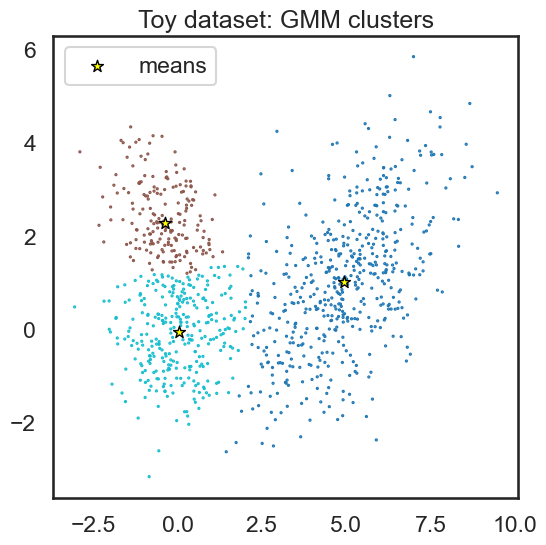

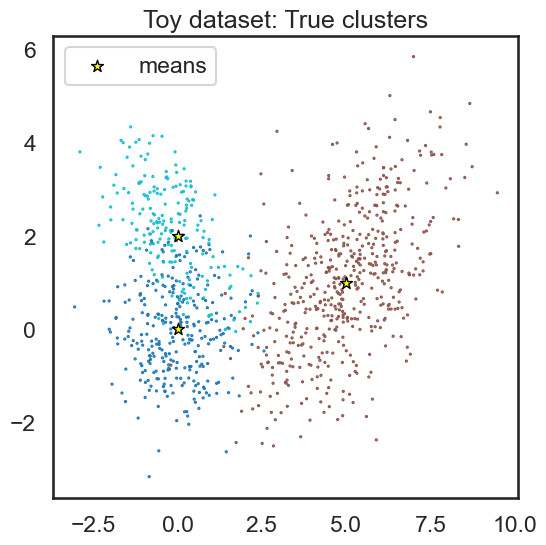

In [50]:
plot_clustering(toy_data,toy_cluster_ids_fit,toy_means_fit,'Toy dataset: GMM clusters')
plot_clustering(toy_data,toy_cluster_ids_true,toy_means,'Toy dataset: True clusters')

It was interesting to compare results to the GMM model from the scikit library

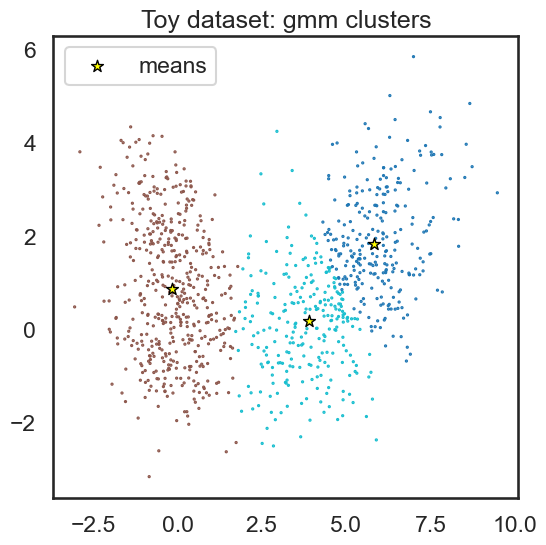

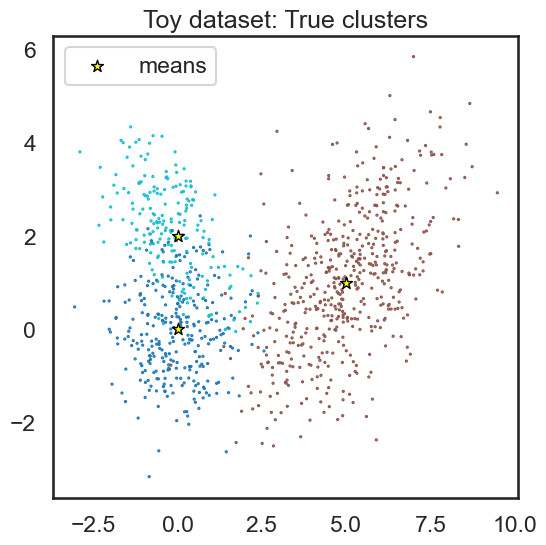

In [51]:
from sklearn.mixture import GaussianMixture
gmm_scikit = GaussianMixture(n_components=3, max_iter=1000).fit(toy_data)
toy_clusters = gmm_scikit.predict(toy_data)
toy_means_fit = gmm_scikit.means_
plot_clustering(toy_data,toy_clusters,toy_means_fit,'Toy dataset: gmm clusters')
plot_clustering(toy_data,toy_cluster_ids_true,toy_means,'Toy dataset: True clusters')

It is interesting to note that compared to the manual gmm, scikit gmm sometimes (not always) produces clusterization, different from the intended one

Now I apply my GMM implementation to the transcriptomics data using `n=50` clusters (as for the k-Means algorithm above). 

In [53]:
# Apply GMM to the Tasic data

data = tasic_1k['PCA_75']
Tasic_cluster_ids_fit, Tasic_means_fit = gmm(data,50)

/Users/a1/miniconda3/envs/fuck2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_43864/3886204252.py:28: RuntimeWarning: divide by zero encountered in log
  scores = np.log(expectation) # calculate the log likelihood of the data given the model


Again compare to the scikit GMM

In [54]:
GMM = GaussianMixture(n_components=50, max_iter=1000).fit(data)
gmm_cluster_ids = GMM.predict(data)

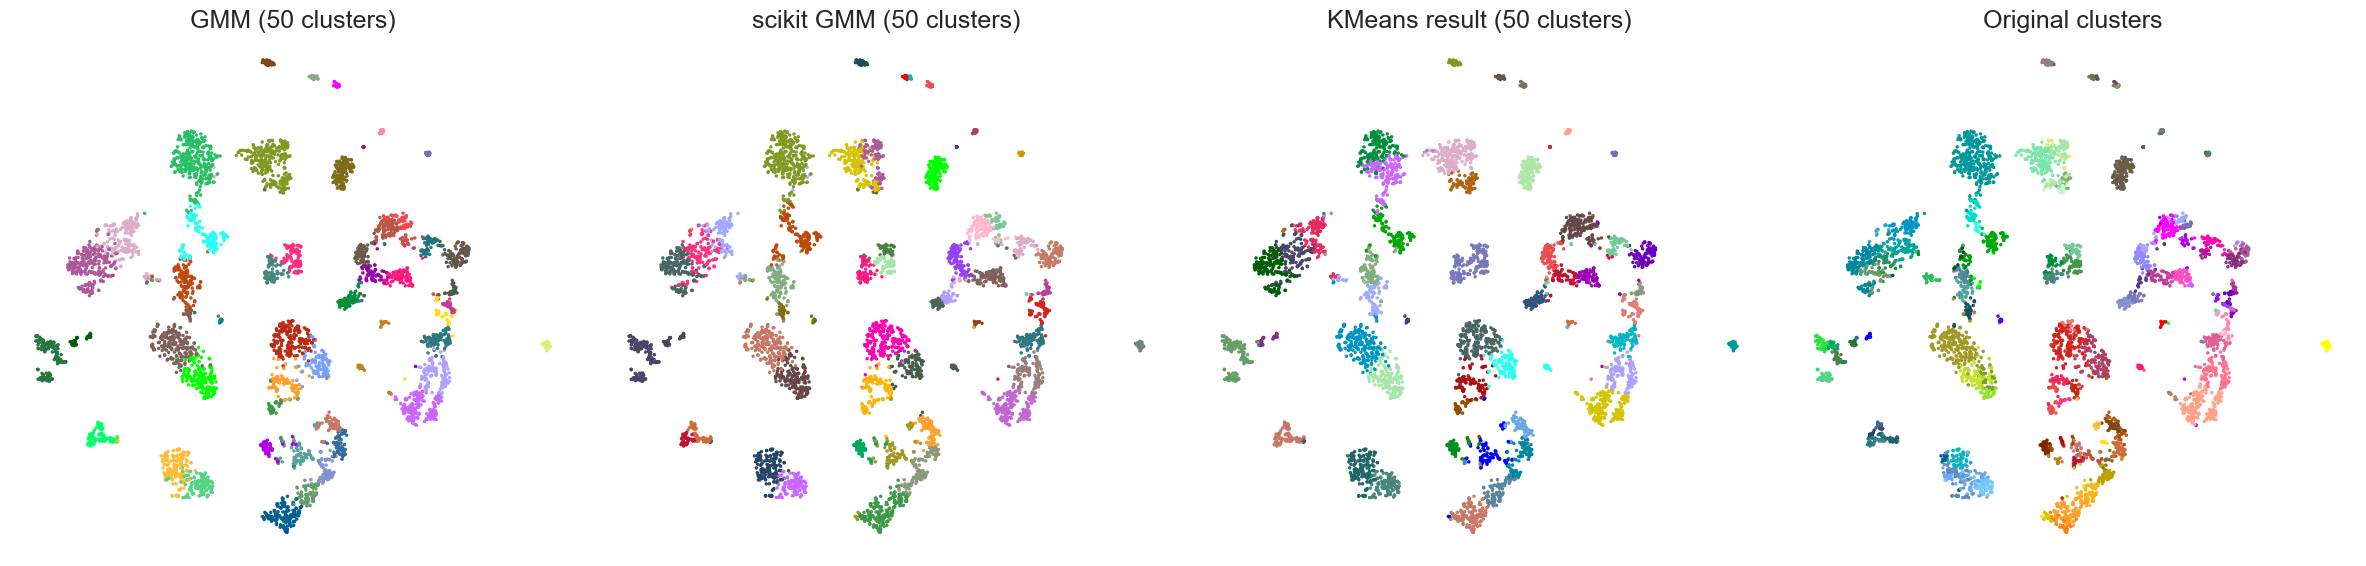

In [55]:
plot_combined_tsne(
    [tsne_results, tsne_results, tsne_results, tsne_results], 
    [np.asarray(Tasic_cluster_ids_fit),gmm_cluster_ids, kmeans_results[3], original_clusters], 
    ["GMM (50 clusters)",'scikit GMM (50 clusters)', "KMeans result (50 clusters)", "Original clusters"],
    tasic_1k, size = (24, 6)
)

First of all, it is worth noting that our implementation of GMM and the Sci-kit GMM have produced very similar clusters.
Next, we can see that the overall data structure (cluster means) look very similar across all methods used and resemble that of the original. However sometimes our clusterisation methods produce 2 clusters where 3 were intended and vice-versa. It is hard to say, which clusterisation algorithm better mirrors the original data. 

Additionally, the color labeling is different to the original. However, this is expected as both GMM and k-Means assign labels to clusters in an arbitrary manner. The color labels or assigned to clusters do not carry any intrinsic meaning and are not consistent across different runs of the algorithm or across different algorithms.   